In [1]:
import numpy as np
import pandas as pd
import sklearn.linear_model
import sklearn.metrics
import os
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier

In [2]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn-v0_8') # pretty matplotlib plots


## Load Data

In [3]:
data_dir = 'data_reviews'
x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv'))
y_train_df = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))

N, n_cols = x_train_df.shape
# print("Shape of x_train_df: (%d, %d)" % (N,n_cols))
# print("Shape of y_train_df: %s" % str(y_train_df.shape))
# x_train_df

In [4]:
# df to list
tr_text_list = x_train_df['text'].values.tolist()

In [5]:
y_train_list = y_train_df['is_positive_sentiment'].values.tolist()


## Partition sentences into words

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
vectorizer = CountVectorizer()

In [8]:
adv_vectorizer = TfidfVectorizer(ngram_range = (1, 2), min_df = 0.001) # considering bigrams, ignore rare words

### How big is my vocabulary?

In [9]:
x = adv_vectorizer.fit_transform(tr_text_list)
vocab = adv_vectorizer.get_feature_names_out()
vocab.size

2368

In [10]:
x_train_NV = x.toarray()
x_train_NV.shape
# N is the number of sentences, and V is the number of vocabulary

(2400, 2368)

In [11]:
N = x_train_NV.shape[0]
V = x_train_NV.shape[1]

### Get the common and rare

In [12]:
# x_common = []

# x_col_sum = np.sum(x_train_NV, axis = 0)

# np.max(x_col_sum)

In [13]:
# x_col_sum.shape, x_col_sum[2701]

In [14]:
# x_common = x_col_sum > N/1.5 # happens half of the time 
# x_common_V = [int(x) for x in x_common]
# x_common_V = np.array(x_common_V)

In [15]:
# x_rare = x_col_sum < 10
# x_rare_V = [int(x) for x in x_rare]
# x_rare_V = np.array(x_rare_V)

In [16]:
# x_common_V.reshape(V, 1)

In [17]:
# x_common = x_train_NV * x_common_V 
# x_rare = x_train_NV * x_rare_V

### Get Normal Vocab

In [18]:
# x_normal = x_train_NV * (1 - x_common_V) * (1 - x_rare_V)
x_normal = x_train_NV

In [19]:
y_train_list = np.array(y_train_list)

In [20]:
%run performance_metrics.py
%run cross_validation.py

In [21]:
M = 2

x_tr_M2 = np.random.randint(2, size=10).reshape(-1, 1)
x_va_N2 = np.random.randint(2, size=10).reshape(-1, 1)
y_tr_M = np.random.randint(2, size=10)
y_va_N = np.random.randint(2, size=10)

## Cross Validation

In [22]:
%run binary_metrics.py
%run proba_metrics.py

In [23]:
K = 5 # num folds of CV
random_state = 1234

train_error_per_fold = np.zeros(K, dtype=np.float32)
test_error_per_fold = np.zeros(K, dtype=np.float32)

N = x_normal.shape[0]
# TODO define the folds here by calling your function
# e.g. ... = make_train_and_test_row_ids_for_n_fold_cv(...)
train_ids, test_ids = make_train_and_test_row_ids_for_n_fold_cv(
    N, K, random_state)

len(train_ids[0]), len(test_ids[0])

(1919, 481)

In [24]:
y_list = y_train_list

## normalize the data

In [25]:
# partition the data into train and test

x_tr, y_tr = list(), list()
y_va, x_va = list(), list()


for i in range(len(train_ids)):
    x_tr.append(x_normal[train_ids[i]])
    y_tr.append(y_list[train_ids[i]])

for i in range(len(test_ids)):
    x_va.append(x_normal[test_ids[i]])
    y_va.append(y_list[test_ids[i]])


In [26]:
C_grid = np.logspace(-4, 5, 15)

In [27]:
cv_tr_bce_list = list()
cv_va_bce_list = list()
cv_te_bce_list = list()



cv_va_auroc_list = list()
cv_tr_auroc_list = list()
va_mean_cv_auroc_list = list()
tr_mean_cv_auroc_list = list()

model_list = list()
tr_bce_list_for_each_C = list()
va_bce_list_for_each_C = list()
# idx = 0
for C in C_grid:

    model_F3_list = list()

    # Allocate lists for storing BCE metrics
    tr_bce_list = list()
    va_bce_list = list()
    te_bce_list = list()
    
    tr_auroc_list = list()
    va_auroc_list = list()

    # idx = idx + 1
    for i in range(K):
        xtr = x_tr[i]
        ytr = y_tr[i]
        xva = x_va[i]
        yva = y_va[i]

        lr_F3 = sklearn.linear_model.LogisticRegression(C = C, penalty = 'l2', solver='lbfgs', max_iter=2000) # TODO fixme
        lr_F3.fit(xtr, ytr) # TODO fixme

        model_F3_list.append(lr_F3)

        yproba1_tr_M = lr_F3.predict_proba(xtr)[:,1] # The probability of predicting class 1 on the training set
        yproba1_va_N = lr_F3.predict_proba(xva)[:,1] # The probability of predicting class 1 on the validation set
        
        
        # get auroc score 
        va_auroc = roc_auc_score(ytr, yproba1_tr_M)
        va_auroc = roc_auc_score(yva, yproba1_va_N)
        tr_auroc_list.append(va_auroc)
        va_auroc_list.append(va_auroc)
        
        my_tr_bce = calc_mean_binary_cross_entropy_from_probas(ytr, yproba1_tr_M) # TODO fixme
        my_va_bce = calc_mean_binary_cross_entropy_from_probas(yva, yproba1_va_N) # TODO fixme
        # Save bce for future selection on Models.
        tr_bce_list.append(my_tr_bce) 
        va_bce_list.append(my_va_bce)
    
    
    va_mean_cv_auroc = sum(va_auroc_list) / len(va_auroc_list)
    va_mean_cv_auroc_list.append(va_mean_cv_auroc)
    
    cv_va_auroc_list.append(va_auroc_list)
    
    tr_mean_cv_auroc = sum(tr_auroc_list) / len(tr_auroc_list)
    tr_mean_cv_auroc_list.append(tr_mean_cv_auroc)
    
    cv_tr_auroc_list.append(tr_auroc_list)
    
    
    tr_bce_list_for_each_C.append(tr_bce_list)
    va_bce_list_for_each_C.append(va_bce_list)
    
    model_list.append(model_F3_list)
    
    
    
    
    
    cv_tr_bce_list.append((sum(tr_bce_list)/len(tr_bce_list)))
    cv_va_bce_list.append((sum(va_bce_list)/len(va_bce_list)))

In [28]:
# cv_tr_bce_list = list()
# cv_va_bce_list = list()
# cv_te_bce_list = list()

# model_list = list()
# tr_bce_list_for_each_C = list()
# va_bce_list_for_each_C = list()
# # idx = 0
# for hl in hl_size_grid:

#     model_F3_list = list()

#     # Allocate lists for storing BCE metrics
#     tr_bce_list = list()
#     va_bce_list = list()
#     te_bce_list = list()

#     # Allocate lists for storing ERROR RATE metrics
#     tr_err_list = list()
#     va_err_list = list()
#     te_err_list = list()

#     # idx = idx + 1
#     for i in range(K):
#         xtr = x_tr[i]
#         ytr = y_tr[i]
#         xva = x_va[i]
#         yva = y_va[i]

#         mlp = MLPClassifier(hidden_layer_sizes= hl, max_iter=1000, alpha=0.0001, solver='lbfgs',
#                     random_state=1234, learning_rate_init=0.001)
#         mlp.fit(xtr, ytr)
        
#         model_F3_list.append(mlp)

#         yproba1_tr_M = mlp.predict_proba(xtr)[:,1]
#         yproba1_va_N = mlp.predict_proba(xva)[:,1]


#         # Compute error rate aka zero-one loss
#         my_tr_err = sklearn.metrics.zero_one_loss(ytr, yproba1_tr_M >= 0.5)
#         my_va_err = sklearn.metrics.zero_one_loss(yva, yproba1_va_N >= 0.5)
#         tr_err_list.append(my_tr_err)
#         va_err_list.append(my_va_err)

#         # TODO: using the calc_mean_binary_cross_entropy_from_probas() function from above:
#         # Part c: calculate the binary cross entropy (bce) on the training set
#         # Part d: calculate the binary cross entropy (bce) on the validation set
#         my_tr_bce = calc_mean_binary_cross_entropy_from_probas(ytr, yproba1_tr_M) # TODO fixme
#         my_va_bce = calc_mean_binary_cross_entropy_from_probas(yva, yproba1_va_N) # TODO fixme
#         # Save bce for future selection on Models.
#         tr_bce_list.append(my_tr_bce) 
#         va_bce_list.append(my_va_bce)
    
#     tr_bce_list_for_each_C.append(tr_bce_list)
#     va_bce_list_for_each_C.append(va_bce_list)
    
#     model_list.append(model_F3_list)
    
#     cv_tr_bce_list.append((sum(tr_bce_list)/len(tr_bce_list)))
#     cv_va_bce_list.append((sum(va_bce_list)/len(va_bce_list)))
    
    


In [29]:
# tr_bce_list_for_each_C

In [30]:
best_C_index = np.argmax(va_mean_cv_auroc_list)
best_C_index

7

In [33]:
best_fold_in_C = np.argmax(cv_va_auroc_list[best_C_index])

In [34]:
best_C__lr = C_grid[best_C_index]
best_lr = model_list[best_C_index][best_fold_in_C]

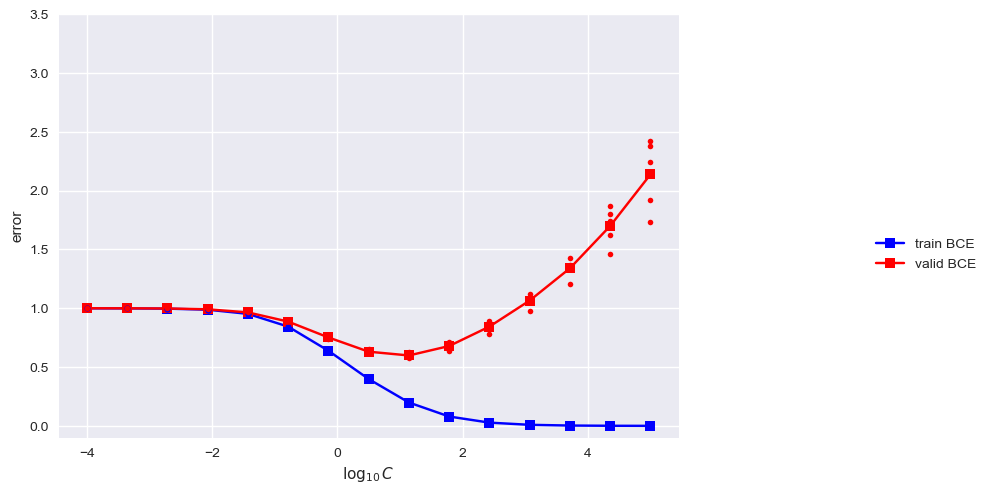

In [35]:
plt.plot(np.log10(C_grid), cv_tr_bce_list, 'bs-', label='train BCE')
plt.plot(np.log10(C_grid), cv_va_bce_list, 'rs-', label='valid BCE')

# for j in range(len(hl_size_grid)):
#     plt.plot(hl_size_grid[j][0] *hl_size_grid[j][1] , cv_tr_bce_list[j], 'bs-', label='train BCE')
#     plt.plot(hl_size_grid[j][0] *hl_size_grid[j][1], cv_va_bce_list[j], 'rs-', label='valid BCE')


for i in range(len(tr_bce_list_for_each_C)):
    for j in range(len(tr_bce_list_for_each_C[0])):
        plt.plot(np.log10(C_grid[i]), tr_bce_list_for_each_C[i][j], marker='o', color='blue', markersize = 4)
        plt.plot(np.log10(C_grid[i]), va_bce_list_for_each_C[i][j], marker='o', color='red', markersize = 4)
        
plt.ylabel('error')
plt.xlabel("$\log_{10} C$");
plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
plt.ylim([-0.1, 3.5]);

In [36]:
# print("Best model has coefficient values:")
# print(best_lr.coef_)

In [37]:
prng = np.random.RandomState(101)

bestlr_yproba1_tr = best_lr.predict_proba(x_tr[best_fold_in_C])[:,1] # TODO fixme
bestlr_yproba1_va = best_lr.predict_proba(x_va[best_fold_in_C])[:,1] # TODO fixme

In [38]:
# bestlr_yproba1_va.shape
# y_va[best_fold_in_C].shape

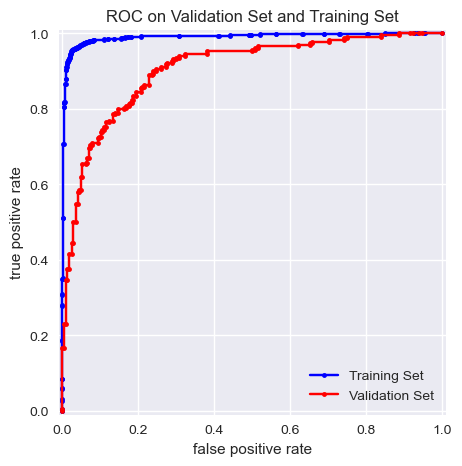

In [39]:
# Follow the instruction of HW2 and produce Figure 1 for your report:
plt.subplots(nrows=1, ncols=1, figsize=(5,5));

# TODO Use provided data and predictions on the Validation set
# Produce the ROC Curve utilizing `sklearn.metrics.roc_curve' within plt defined above.
# To start, read the official Document and examples of 'sklearn.metrics.roc_curve'. 
va_fpr, va_tpr, va_thresholds = sklearn.metrics.roc_curve(y_va[best_fold_in_C], bestlr_yproba1_va)
tr_fpr, tr_tpr, tr_thresholds = sklearn.metrics.roc_curve(y_tr[best_fold_in_C], bestlr_yproba1_tr)

# Read HW2 instructions carefully for plot style (line type, line color, etc.)

plt.plot(tr_fpr, tr_tpr, 'b.-', label = "Training Set" )
plt.plot(va_fpr, va_tpr, 'r.-', label = "Validation Set" )
plt.title("ROC on Validation Set and Training Set");
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');
plt.legend(loc='lower right');
B = 0.01
plt.xlim([0 - B, 1 + B]);
plt.ylim([0 - B, 1 + B]);

## Confusion Matrix on the best C/fold

In [40]:
import threshold_selection
from confusion_matrix import calc_confusion_matrix_for_probas_and_threshold

In [41]:
best_thr_default = 0.5

print(sklearn.metrics.confusion_matrix(y_va[best_fold_in_C], bestlr_yproba1_va >= best_thr_default))

thresh_grid, perf_dict = threshold_selection.compute_perf_metrics_across_thresholds(y_va[best_fold_in_C], bestlr_yproba1_va, [best_thr_default])

tpr = perf_dict['tpr'][0]# TODO fixme
ppv = perf_dict['ppv'][0] # TODO fixme

print(f"chosen thr = {best_thr_default :.4f}, tpr = {tpr :.4f}, ppv = {ppv :.4f},")

[[214  33]
 [ 54 180]]
chosen thr = 0.5000, tpr = 0.7692, ppv = 0.8451,


## Area Under ROC Curve

In [42]:
roc_auc_score(y_va[best_fold_in_C],bestlr_yproba1_va)

0.9067787812727084

## read the test file into vocab matrix

In [ ]:
x_test_df = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))
x_test_df.shape

In [ ]:
te_text_list = x_test_df['text'].values.tolist()
len(te_text_list)

In [ ]:
vec = CountVectorizer(vocabulary = vocab)
t = vec.fit_transform(te_text_list)
t

In [ ]:
te_array = t.toarray()
te_array.shape

In [ ]:
y_te_proba = best_lr.predict_proba(te_array)[:,1]
y_te_proba